# LangGraph Crash Course

This Jupyter Notebook provides a hands-on introduction to LangGraph, demonstrating its core ideas with actual `langgraph` code examples. You'll learn how to define state, create nodes, set up edges, and leverage advanced features like checkpointers and human-in-the-loop.

**Note:** Tis course only covers the Graph API of `langgraph` framework.

Why use LangGraph?
1. **Build Complex AI Workflows**: Design sophisticated AI applications by breaking them into manageable steps (nodes) and enabling your AI to make smart, dynamic decisions (edges) based on a persistent, shared memory.

2. **Enhance Control & Debugging**: Integrate human oversight with breakpoints, and gain full observability to easily debug, inspect, and visualize your AI's decision-making process.

3. **Seamless LangChain Integration**: Leverage your existing LangChain tools, retrievers, and agents effortlessly, making it easy to build powerful and reusable AI components.

In [1]:
!pip -qq install -U langchain langchain-community langgraph pydantic google-ai-generativelanguage==0.6.15 langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 16.1 MB/s eta 0:00:00


In [2]:
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')

## Basics
This section covers the fundamental ideas you need to start building with LangGraph.

LangGraph is a stateful, orchestration framework for building various LLM-powered applications by designing them as a `graph`.
A graph has 3 main components:
1. `State`: A shared object accessible across all nodes in the graph.
2. `Nodes`: Python functions encapsulating agent logic.
3. `Edges`: Python functions that decide the next node to run based on the current state.



### State
The `State` object is the central notepad where all information about your AI's current task is stored. Every part of your AI can read from this notepad and update it.

To define a state we need:
- Schemas: Represents the state structure, can be defined using a `TypedDict` or a pydantic `BaseModel`.
- Reducer functions (Optional): Functions used to update States.

In [3]:
from langgraph.graph import StateGraph
from langchain_core.messages import AnyMessage, HumanMessage

#### Schemas


**Defining State with Typed Dicttionary**

In [4]:
from typing import List, TypedDict

In [5]:
# Define the State using TypedDict
class ChatbotStateTD(TypedDict):
    messages: List[AnyMessage]

In [6]:
# Initial State
initial_state_typeddict = ChatbotStateTD(messages=[])
type(initial_state_typeddict)

dict

In [7]:
print(f"Initial State (TypedDict): {initial_state_typeddict}")

Initial State (TypedDict): {'messages': []}


In [8]:
# Initial State with dictionary
initial_state_typeddict = ChatbotStateTD({"messages": []})

print(f"Initial State (TypedDict): {initial_state_typeddict}")

Initial State (TypedDict): {'messages': []}


In [9]:
# Initial State with wrong types
initial_state_typeddict_1 = ChatbotStateTD({"messages": True})
initial_state_typeddict_2 = ChatbotStateTD({"messages": ["hello"]})

print(f"{initial_state_typeddict_1=}\n{initial_state_typeddict_2=}")

initial_state_typeddict_1={'messages': True}
initial_state_typeddict_2={'messages': ['hello']}


**Defining State with pydantic BaseModel**

In [10]:
from pydantic import BaseModel, Field

In [11]:
# Define the State using TypedDict
class ChatbotStateBM(BaseModel):
    messages: List[AnyMessage] = Field(default_factory=list)

In [12]:
# Initial State
initial_state_pydantic = ChatbotStateBM()
initial_state_pydantic

ChatbotStateBM(messages=[])

In [13]:
print(f"Initial State (Pydantic): {initial_state_pydantic}")
print(f"Initial State (Pydantic): {initial_state_pydantic.model_dump()}")

Initial State (Pydantic): messages=[]
Initial State (Pydantic): {'messages': []}


In [14]:
# Initial State with non-default value
initial_state_pydantic = ChatbotStateBM(messages=[HumanMessage("Hello!")])
initial_state_pydantic

ChatbotStateBM(messages=[HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={})])

In [15]:
# Initial State with wrong type
initial_state_pydantic = ChatbotStateBM(messages="Hello!")

ValidationError: 1 validation error for ChatbotStateBM
messages
  Input should be a valid list [type=list_type, input_value='Hello!', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/list_type

**Note:**
Instead of a single, shared data schema for all nodes, LangGraph lets you define multiple schemas to:

- **Control Internal Data:** Keep intermediate information private between nodes, preventing it from cluttering the main input/output.

- **Tailor Graph I/O:** Define specific input and output schemas for the overall graph, allowing you to expose only the relevant data to external systems.

In [16]:
# Define graph with multiple states (input, internal, and output)
class InputState(TypedDict):
    user_input: str

class OutputState(TypedDict):
    graph_output: str

class InternalState(TypedDict):
    internal_var: str
    user_input: str
    graph_output: str

graph = StateGraph(InternalState, input_schema=InputState, output_schema=OutputState)

#### We can also define private input and output state node states (images)

#### Reducers

In this segment, we'll just see how to define reducers, but we'll see them in action afterward.

In [17]:
# Default reducer function
class State(TypedDict):
    foo: int
    bar: str
    baz: float

In [18]:
# Cutom reducer function
from typing import Annotated
from operator import add

def custom_reducer(old_value, new_value) -> float:
  return (old_value + new_value)/2

def increment(old_value, new_value) -> int:
  return old_value + 1

class State(TypedDict):
    foo: Annotated[float, custom_reducer]
    baz: Annotated[int, increment] # Count nbr of updates
    bar: Annotated[list[str], add]

### Nodes

LangGraph nodes are Python functions that primarily receive the graph's state as their first argument. They can also accept an optional config argument for parameters like thread_id. You integrate these functions into your graph using the add_node method.

In [19]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

In [20]:
# define state
class State(TypedDict):
    messages: Annotated[list, add_messages]

# define chatbot 1 node
def chatbot1(state: State) -> State:
    llm_response = "Hello from the chatbot1!"
    return {"messages": [llm_response]}

# define chatbot 2 node
def chatbot2(state: State) -> State:
    llm_response = "Hello from the chatbot2!"
    return {"messages": [llm_response]}

We have define a state and a node, we can now start building our graph!

In [21]:
# Instantiate a graph builder
graph_builder = StateGraph(State)

# Add node
graph_builder.add_node("chatbot1", chatbot1)

# We can also add caching to an expensive node
graph_builder.add_node("chatbot2", chatbot2)

There are many options when adding a node to a graph:
- Passing an `input_schema`
- Deferring node execution
- Use caching for expensive nodes.
- Destinations for edgeless graphs.

We can't compile and run our graph yet, because we need Edges to define the flow in our graph!

In [22]:
graph_builder.compile()

ValueError: Graph must have an entrypoint: add at least one edge from START to another node

### Edges

Edges define graph flow and termination. They can be normal (direct), conditional (function-based routing), or specify entry points (can be  conditional). Crucially, a node with multiple outgoing edges will execute all destination nodes in parallel, which are then considered part of the same super-step.

In [23]:
from langgraph.graph import START, END

In [24]:
# define normal (direct) edge
graph_builder.add_edge(START, "chatbot1")

In [25]:
# define conditional edge
def routing_function(state: State) -> str:
    if len(state["messages"]) > 1000:
        return "chatbot2"
    return "chatbot1"

graph_builder.add_conditional_edges(START, routing_function)

In [26]:
# define conditional edge with path mapping
def use_chatbot2(state: State) -> str:
    if len(state["messages"]) > 1000:
        return True
    return False

graph_builder.add_conditional_edges(START, use_chatbot2, {True: "chatbot2", False:"chatbot1"})

### Defining & Compiling a graph

Now that we have seen the basic components that are used to define a graph in `langgraph`, let's see how to build, compile, and run it.

As a first example we will see how to build a simple chatbot with `langgrapph`.

In [27]:
from typing import Annotated, List
from pydantic import BaseModel

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import AnyMessage
from langchain_google_genai import ChatGoogleGenerativeAI

In [28]:
# define chat model
gemini = ChatGoogleGenerativeAI(
      model="models/gemini-2.0-flash",
      temperature=0,
      api_key=GEMINI_API_KEY
)

In [29]:
# define state
class MessageState(BaseModel):
    messages: Annotated[List[AnyMessage], add_messages]  # from langgraph.graph import MessagesState


# define chatbot node
def chatbot(state: MessageState):
    reponse = gemini.invoke(state.messages)
    return {"messages": [reponse]}

# create graph
graph_builder = StateGraph(MessageState)

# add nodes
graph_builder.add_node("chatbot", chatbot)

# add edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# compile graph
graph = graph_builder.compile()

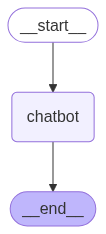

In [30]:
# visualize graph
graph

In [31]:
# run graph with invoke
final_state = graph.invoke({"messages":[{"role":"user",
                                         "content":"Hello!"
                                         }]
                            }) # can work with just ["hello!"] because we used predefined reducer

In [32]:
final_state

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='c9cf710b-f13b-4f6b-80b0-dd1ea58b188c'),
  AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--5a07c03b-0899-431b-a99d-7a9084f6059f-0', usage_metadata={'input_tokens': 2, 'output_tokens': 10, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})]}

In [33]:
final_state["messages"][-1].content

'Hello! How can I help you today?'

In [73]:
# run graph with stream
final_state = graph.stream({"messages":["hello!"]}, stream_mode="values") # Emit all values in the state after each step

In [74]:
final_state

<generator object Pregel.stream at 0x7b834627cd60>

In [58]:
list(final_state)

[{'messages': [HumanMessage(content='hello!', additional_kwargs={}, response_metadata={}, id='fbe52028-5aca-47e9-8935-a656ad5c756e')]},
 {'messages': [HumanMessage(content='hello!', additional_kwargs={}, response_metadata={}, id='fbe52028-5aca-47e9-8935-a656ad5c756e'),
   AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--448453d2-5fa6-4a8a-bc7f-a361558a7cf5-0', usage_metadata={'input_tokens': 2, 'output_tokens': 10, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})]}]

In [75]:
import time

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        message.pretty_print()
        time.sleep(1)

In [76]:
print_stream(final_state)

================================ Human Message =================================

hello!
================================== Ai Message ==================================

Hello! How can I help you today?


## Advanced Concepts & Design Patterns

In this section, we'll cover few advanced concepts and design patterns that are imporant to build more sophisticated graphs and workflows.

You'll learn the following:
- Runtime Configuration (Runnable Config).
- Command API for Dynamic Node Routing and State Updates.
- Persistence with checkpointers (Chat History & HITL).
- Map-reduce design pattern with Send API.
- Loops and Recursion limit.




### Runtime configuration

Runtime configuration allows you to dynamically set parameters like the LLM or system prompt that can be used within nodes and conditional edges, without cluttering the graph's internal state.

In [77]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

class ConfigSchema(TypedDict):
    llm_model: str

def chatbot(state: State, config:RunnableConfig) -> State:
    if config["configurable"]["llm_model"] == "gemini":
        llm_response = "Hello from the Gemini chatbot!"
    elif config["configurable"]["llm_model"] == "openai":
        llm_response = "Hello from the OpenAI chatbot!"
    else:
        raise(ValueError("Invalid/Unsupported LLM model."))
    return {"messages": [llm_response]}

builder = StateGraph(State, config_schema=ConfigSchema)

builder.add_node("chatbot", chatbot)

builder.set_entry_point("chatbot")
builder.set_finish_point("chatbot")

graph = builder.compile()

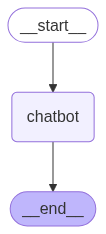

In [78]:
graph

In [ ]:
config_with_gemini = {"configurable": {"llm_model": "gemini"}}
config_with_openai = {"configurable": {"llm_model": "openai"}}

final_state_1 = graph.invoke({"messages":["Hello!"]}, config_with_gemini)
final_state_2 = graph.invoke({"messages":["Hello!"]}, config_with_openai)

In [ ]:
final_state_1["messages"][-1].content, final_state_2["messages"][-1].content

('Hello from the Gemini chatbot!', 'Hello from the OpenAI chatbot!')

In [ ]:
config_with_wrong_llm = {"configurable": {"llm_model": "grok"}}
final_state = graph.invoke({"messages":["Hello!"]}, config_with_wrong_llm)

ValueError: Invalid/Unsupported LLM model.

### Dynamic node routing & state updates

You can think of it as combining a node with an edge or a conditional edge.
This allows us to streamline our graph by allowing a single node to both update the graph's state and dictate the subsequent flow.

This is achieved by having the node function return a Command object, which specifies the next step.

In [79]:
import random
from typing_extensions import Literal
from langgraph.types import Command

In [80]:
# Define the Graph State
class CoinFlipState(TypedDict):
    result: str
    message: str

# Define the Nodes
def initialize_state(state: CoinFlipState):
    return {"result": "unset", "message": "Ready to flip the coin!"}

def flip_coin(state: CoinFlipState) -> Command[Literal["heads_action", "tails_action"]]:
    coin_outcome = random.choice(["Heads", "Tails"])

    if coin_outcome == "Heads":
        next_node = "heads_action"
        update_message = "It's Heads!"
    else:
        next_node = "tails_action"
        update_message = "It's Tails!"
    return Command(
        update={"result": coin_outcome, "message": update_message},
        goto=next_node,
    )

def heads_action(state: CoinFlipState):
    return {"message": state["message"] + " We got lucky!"}

def tails_action(state: CoinFlipState):
    return {"message": state["message"] + " Better luck next time."}

# Build the Graph
builder = StateGraph(CoinFlipState)

# Add nodes to the graph
builder.add_node("initialize_state", initialize_state)
builder.add_node("flip_coin", flip_coin)
builder.add_node("heads_action", heads_action)
builder.add_node("tails_action", tails_action)

# Define edges
builder.add_edge(START, "initialize_state")
builder.add_edge("initialize_state", "flip_coin")

# Edges from the action nodes to the END
builder.add_edge("heads_action", END)
builder.add_edge("tails_action", END)

# Compile the graph
graph = builder.compile()

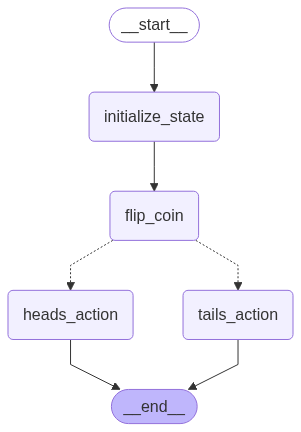

In [81]:
graph

In [82]:
# Run the Graph multiple times
final_state_1 = graph.invoke({})
final_state_2 = graph.invoke({})
final_state_3 = graph.invoke({})
print(f"{final_state_1=}\n{final_state_2=}\n{final_state_3=}")

final_state_1={'result': 'Heads', 'message': "It's Heads! We got lucky!"}
final_state_2={'result': 'Tails', 'message': "It's Tails! Better luck next time."}
final_state_3={'result': 'Tails', 'message': "It's Tails! Better luck next time."}


The `Command` class offers more capabilities beyond this, and you can find more about it in the LangGraph documentation.

### Persistence

LangGraph has a built-in persistence layer, which is managed by checkpointers.

When a graph is compiled with a `checkpointer`, it automatically saves a checkpoint of the graph's state after each super-step.

These checkpoints are stored within a specific `thread`, which remains accessible even after the graph's execution is complete.


---


We will see how to use the checkpointers and threads to implement memory in chatbots and how to design human-in-the-loop pattern with the interrupt function.

#### Memory & Snapshots

Create chatbot with memory and investigate its state history snapshots.

In [83]:
from langgraph.graph import StateGraph, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI

# class State(TypedDict):
#     messages: Annotated[list, add_messages]
builder = StateGraph(MessagesState) # view source

gemini = ChatGoogleGenerativeAI(
      model="models/gemini-2.0-flash",
      temperature=0,
      api_key=GEMINI_API_KEY
)

def chatbot(state: MessagesState):
    return {"messages": [gemini.invoke(state["messages"])]}

builder.add_node("chatbot", chatbot)
builder.set_entry_point("chatbot")
builder.set_finish_point("chatbot")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

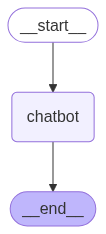

In [84]:
graph

In [85]:
config = {"configurable": {"thread_id": "1"}}
final_state_1 = graph.invoke({"messages": ["Hi, my name is Hamza."]}, config)

In [86]:
for m in final_state_1["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Hamza.
================================== Ai Message ==================================

Hi Hamza, it's nice to meet you! How can I help you today?


In [87]:
final_state_2 = graph.invoke({"messages": ["do you remember my name?"]}, config)

In [88]:
for m in final_state_2["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Hamza.
================================== Ai Message ==================================

Hi Hamza, it's nice to meet you! How can I help you today?
================================ Human Message =================================

do you remember my name?
================================== Ai Message ==================================

Yes, Hamza. I remember your name.


In [92]:
final_snapshot = graph.get_state(config)
final_snapshot # check . options

StateSnapshot(values={'messages': [HumanMessage(content='Hi, my name is Hamza.', additional_kwargs={}, response_metadata={}, id='40c5ca25-d9f5-4cd9-8b61-043e409fbfdc'), AIMessage(content="Hi Hamza, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--e2cfffab-707f-4d0a-a68d-9f62cc769f7f-0', usage_metadata={'input_tokens': 7, 'output_tokens': 19, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='do you remember my name?', additional_kwargs={}, response_metadata={}, id='5a6070b2-a1bf-4e04-a1ef-8b5abcc9d599'), AIMessage(content='Yes, Hamza. I remember your name.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--96638fcd-72cd-42c7-93a1-e30dbcfbf699-0', usage_metadata={'input_tokens': 31, '

In [93]:
for snapshot in graph.get_state_history(config):
  print(snapshot.values)
  print(snapshot.next)
  print("-"*20)

{'messages': [HumanMessage(content='Hi, my name is Hamza.', additional_kwargs={}, response_metadata={}, id='40c5ca25-d9f5-4cd9-8b61-043e409fbfdc'), AIMessage(content="Hi Hamza, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--e2cfffab-707f-4d0a-a68d-9f62cc769f7f-0', usage_metadata={'input_tokens': 7, 'output_tokens': 19, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='do you remember my name?', additional_kwargs={}, response_metadata={}, id='5a6070b2-a1bf-4e04-a1ef-8b5abcc9d599'), AIMessage(content='Yes, Hamza. I remember your name.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--96638fcd-72cd-42c7-93a1-e30dbcfbf699-0', usage_metadata={'input_tokens': 31, 'output_tokens': 10, '

#### Interruptions

Build a chatbot with tool calling capabilities that calls for human assistance when needed.

In [94]:
from typing import Annotated

from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

In [95]:
gemini = ChatGoogleGenerativeAI(
      model="models/gemini-2.0-flash",
      temperature=0,
      api_key=GEMINI_API_KEY
)

builder = StateGraph(MessagesState)

@tool
def human_assistance(query: str) -> str:
    """Useful for when you need human assistance."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tools = [human_assistance]
gemini_with_tools = gemini.bind_tools(tools)

def chatbot(state: MessagesState):
    message = gemini_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}

builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
builder.add_node("tools", tool_node)

builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

builder.add_edge("tools", "chatbot")
builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

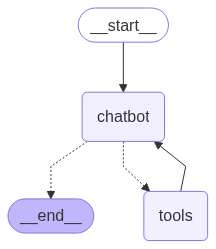

In [96]:
graph

In [97]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

final_state = graph.invoke({"messages": [user_input]}, config)
for m in final_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (dcc1f2f2-f1f5-492c-a5c6-dced6573407b)
 Call ID: dcc1f2f2-f1f5-492c-a5c6-dced6573407b
  Args:
    query: I need expert guidance on building an AI agent.


In [98]:
human_response = """
    We, the experts are here to help! check out Machine Learning with Hamza on youtube for guidance.
"""

human_command = Command(resume={"data": human_response})

final_state = graph.invoke(human_command, config)

In [99]:
for m in final_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (dcc1f2f2-f1f5-492c-a5c6-dced6573407b)
 Call ID: dcc1f2f2-f1f5-492c-a5c6-dced6573407b
  Args:
    query: I need expert guidance on building an AI agent.
================================= Tool Message =================================
Name: human_assistance


    We, the experts are here to help! check out Machine Learning with Hamza on youtube for guidance.

================================== Ai Message ==================================

OK. I've requested human assistance for you. The suggestion is to check out "Machine Learning with Hamza" on YouTube for guidance.


### Map-Reduce

In LangGraph we can implement the map-reduce design pattern through the Send API.

1. A Send object is used to define a packet to send to a specific node in the graph. The packet contains the destination node and a state that can be different from the defined graph state.

2. MapReduce is a programming model usually used for processing large datasets by dividing the task into two main phases:
  - The map phase: In which the data is processes in parallel.
  - The reduce phase: In which we aggregates the results from the map phase.

Create a graph that uses map-reduce to calculate the square of each integer in a list.

In [100]:
from langgraph.types import Send
from typing import Annotated
from operator import add

In [101]:
class OverallState(TypedDict):
    numbers: list[int]
    squared: Annotated[list[str], add]

def continue_to_squaring(state: OverallState):
    return [Send("calculate_square", {"number": n}) for n in state['numbers']]

builder = StateGraph(OverallState)

builder.add_node("calculate_square", lambda state: {"squared": [state["number"]**2]})

builder.add_conditional_edges(START, continue_to_squaring)
builder.add_edge("calculate_square", END)

graph = builder.compile()

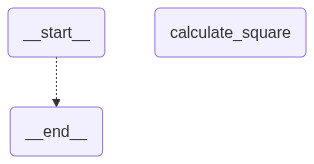

In [102]:
graph

In [103]:
# Invoking with list of integers
graph.invoke({"numbers": [1,2,3,4]})

{'numbers': [1, 2, 3, 4], 'squared': [1, 4, 9, 16]}

### Loops & Recursion Limit

Create a graph with looping behavior between nodes

In [ ]:
# Define reducer for the 'index' key
def increment_reducer(current_value: int, new_value_from_node: any) -> int:
    return current_value + 1

# Define the Graph State with an 'index'
class LoopState(TypedDict):
    index: Annotated[int, increment_reducer]  # This will track our loop's progress
    output_data: str # Example of other data

# Define a simple node
def loop_iteration_node(state: LoopState) -> LoopState:
    print(f"Processing step {state['index']}")
    return {"index": 0, "output_data": f"Processed at step {state['index']}"}

def should_continue(state: LoopState) -> bool:
    if state["index"] <= 30:
      return "continue"
    return "end"

# Build the Graph with the custom reducer
builder = StateGraph(LoopState)

# Add the node to the workflow
builder.add_node("iterate", loop_iteration_node)

# Add the edges
builder.set_entry_point("iterate")
builder.add_conditional_edges("iterate", should_continue, {"continue": "iterate", "end":END})

# Compile the graph
graph = builder.compile()

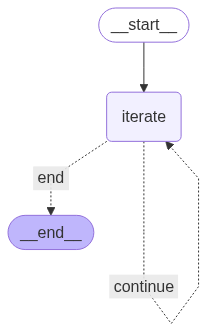

In [ ]:
graph

In [ ]:
# Invoke the graph and observe the 'index' increment
initial_state = {"index": 0, "output_data": "start"}

final_state = graph.invoke(initial_state)

Processing step 1
Processing step 2
Processing step 3
Processing step 4
Processing step 5
Processing step 6
Processing step 7
Processing step 8
Processing step 9
Processing step 10
Processing step 11
Processing step 12
Processing step 13
Processing step 14
Processing step 15
Processing step 16
Processing step 17
Processing step 18
Processing step 19
Processing step 20
Processing step 21
Processing step 22
Processing step 23
Processing step 24
Processing step 25


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
final_state = graph.invoke(initial_state, {"recursion_limit": 50})

Processing step 1
Processing step 2
Processing step 3
Processing step 4
Processing step 5
Processing step 6
Processing step 7
Processing step 8
Processing step 9
Processing step 10
Processing step 11
Processing step 12
Processing step 13
Processing step 14
Processing step 15
Processing step 16
Processing step 17
Processing step 18
Processing step 19
Processing step 20
Processing step 21
Processing step 22
Processing step 23
Processing step 24
Processing step 25
Processing step 26
Processing step 27
Processing step 28
Processing step 29
Processing step 30


## ReAct and DeepSearch Agent Examples

### ReAct Agent with HITL

In [ ]:
import json
import random
from typing import List, Any, Annotated
from typing_extensions import TypedDict
from langchain_core.messages import ToolMessage, SystemMessage, AnyMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, END

In [ ]:
gemini = ChatGoogleGenerativeAI(
      model="models/gemini-2.0-flash",
      temperature=0,
      api_key=GEMINI_API_KEY
)

@tool
def human_assistance(query: str) -> str:
    """
    This tool is useful when human assistance is requested.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]

@tool
def faq_responses(query: str) -> str:
    """
    This tool is useful to answer frequently asked questions about the company.
    """
    fqa_response = random.choice(["The company was founded in 2025.","No answer found in database"])
    return fqa_response


tools = [human_assistance, faq_responses]

gemini_with_tools = gemini.bind_tools(tools)

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

tools_by_name = {tool.name: tool for tool in tools}

# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(state: AgentState):
    system_prompt = SystemMessage(
        """
        You are a customer-service assistant.
        You have tools that give you access to a FAQ database and human assistnace.
        When asked about the company, always check with the FAQ database first, and if no answer or unrelated is found, use human assistance.
        """
    )
    response = gemini_with_tools.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


# Define the conditional edge function
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    return "continue"

In [ ]:
# Define a new graph
builder = StateGraph(AgentState)

# Add nodes
builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)

# Add edges (ReAct loop)
builder.set_entry_point("agent")
builder.add_conditional_edges("agent", should_continue, {"continue": "tools","end": END})
builder.add_edge("tools", "agent")

# Now we can compile and visualize our graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

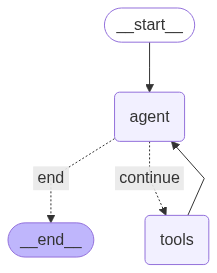

In [ ]:
graph

In [ ]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": ["When was the company founded"]}
final_state = graph.invoke(inputs, config)

In [ ]:
for m in final_state["messages"]:
  m.pretty_print()

================================ Human Message =================================

When was the company founded
================================== Ai Message ==================================
Tool Calls:
  faq_responses (290396d8-b1de-49eb-9974-76a655ea6628)
 Call ID: 290396d8-b1de-49eb-9974-76a655ea6628
  Args:
    query: When was the company founded
================================= Tool Message =================================
Name: faq_responses

"The company was founded in 2025."
================================== Ai Message ==================================

The company was founded in 2025.


In [ ]:
config = {"configurable": {"thread_id": "3"}}
inputs = {"messages": ["Who's the company founder?"]}
final_state = graph.invoke(inputs, config)

In [ ]:
for m in final_state["messages"]:
  m.pretty_print()

================================ Human Message =================================

Who's the company founder?
================================== Ai Message ==================================
Tool Calls:
  faq_responses (1f1f682e-a222-4bb5-8492-5544c32a2a90)
 Call ID: 1f1f682e-a222-4bb5-8492-5544c32a2a90
  Args:
    query: Who's the company founder?
================================= Tool Message =================================
Name: faq_responses

"The company was founded in 2025."
================================== Ai Message ==================================

I don't have the answer to your question in the FAQ. I will ask for human assistance.
Tool Calls:
  human_assistance (8c565257-1eb1-41f4-9131-dcdf896aea12)
 Call ID: 8c565257-1eb1-41f4-9131-dcdf896aea12
  Args:
    query: Who's the company founder?


In [ ]:
human_response = "The company founder is Hamza"

human_command = Command(resume={"data": human_response})

final_state = graph.invoke(human_command, config)

In [ ]:
for m in final_state["messages"]:
  m.pretty_print()

================================ Human Message =================================

Who's the company founder?
================================== Ai Message ==================================
Tool Calls:
  faq_responses (1f1f682e-a222-4bb5-8492-5544c32a2a90)
 Call ID: 1f1f682e-a222-4bb5-8492-5544c32a2a90
  Args:
    query: Who's the company founder?
================================= Tool Message =================================
Name: faq_responses

"The company was founded in 2025."
================================== Ai Message ==================================

I don't have the answer to your question in the FAQ. I will ask for human assistance.
Tool Calls:
  human_assistance (8c565257-1eb1-41f4-9131-dcdf896aea12)
 Call ID: 8c565257-1eb1-41f4-9131-dcdf896aea12
  Args:
    query: Who's the company founder?
================================= Tool Message =================================
Name: human_assistance

"The company founder is Hamza"
================================== Ai Message 

### Deep Search ReAct Agent

In [ ]:
!pip -qq install -U googlesearch-python mistralai PyPDF2 crawl4ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.8/381.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not current

In [ ]:
!crawl4ai-setup

[INIT].... → Running post-installation setup... 
[INIT].... → Installing Playwright browsers... 
Installing dependencies...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,077 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,092 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 ht

In [ ]:
!playwright install

92.3 MiB [] 0% 0.0s92.3 MiB [] 0% 153.2s92.3 MiB [] 0% 157.1s92.3 MiB [] 0% 90.5s92.3 MiB [] 0% 91.2s92.3 MiB [] 0% 67.5s92.3 MiB [] 0% 57.0s92.3 MiB [] 0% 42.9s92.3 MiB [] 0% 32.7s92.3 MiB [] 0% 33.8s92.3 MiB [] 1% 26.2s92.3 MiB [] 1% 20.0s92.3 MiB [] 1% 19.9s92.3 MiB [] 1% 15.7s92.3 MiB [] 2% 11.9s92.3 MiB [] 3% 11.4s92.3 MiB [] 3% 9.2s92.3 MiB [] 5% 6.5s92.3 MiB [] 6% 6.3s92.3 MiB [] 7% 5.2s92.3 MiB [] 8% 4.5s92.3 MiB [] 10% 4.0s92.3 MiB [] 10% 4.1s92.3 MiB [] 12% 3.5s92.3 MiB [] 13% 3.2s92.3 MiB [] 14% 3.0s92.3 MiB [] 16% 2.7s92.3 MiB [] 17% 2.7s92.3 MiB [] 18% 2.5s92.3 MiB [] 20% 2.3s92.3 MiB [] 21% 2.2s92.3 MiB [] 22% 2.2s92.3 MiB [] 24% 2.0s92.3 MiB [] 25% 1.9s92.3 MiB [] 26% 1.9s92.3 MiB [] 28% 1.7s92.3 MiB [] 29% 1.7s92.3 MiB [] 30% 1.7s92.3 MiB [] 32% 1.6s92.3 MiB [] 33% 1.5s92.3 MiB [] 34% 1.5s92.3 MiB [] 36% 1.4s92.3 MiB [] 37% 1.4s92.3 MiB [] 38% 1.3s92.3 MiB [] 40% 1.3s92.3 MiB [] 41% 1.2s92.3 MiB [] 42% 1.2s92.3 MiB [] 44% 1.1s92.3 MiB [] 45% 1.1s92.3 MiB [] 46% 1.1s92.3

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
MISTRAL_API_KEY = userdata.get('MISTRAL_API_KEY')

In [ ]:
import os
import requests
import json

from typing import Annotated, Tuple, List
from pydantic import BaseModel, Field

from langgraph.prebuilt import create_react_agent # New
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.rate_limiters import InMemoryRateLimiter

from googlesearch import search

import base64
from mistralai import Mistral
from PyPDF2 import PdfReader, PdfWriter

from crawl4ai import AsyncWebCrawler, BrowserConfig, CrawlerRunConfig, CacheMode
from crawl4ai.content_scraping_strategy import LXMLWebScrapingStrategy
from crawl4ai.markdown_generation_strategy import DefaultMarkdownGenerator

In [ ]:
import asyncio
import nest_asyncio

nest_asyncio.apply()

In [ ]:
class PlannerInput(BaseModel):
    query: str = Field(..., description="user's query")

@tool("generate_plan",
    description="Breaks down a user query into sub-questions and optimized web search queries for deep research planning.",
    args_schema=PlannerInput
)
def generate_plan(query: str) -> dict:
    model = ChatGoogleGenerativeAI(
      model="models/gemini-2.0-flash",
      temperature=0,
      max_tokens=None,
      timeout=None,
      max_retries=2,
      api_key=GEMINI_API_KEY
    )

    planning_system_prompt = """
You are an expert Research Analyst and Strategic Planner. Your mission is to deconstruct a user's query into a comprehensive and logical research plan. This plan will be the foundation for generating a thorough, well-supported report.

You must meticulously follow the instructions for each field of the output.

**1. Task: `query_breakdown`**

Your first task is to deeply analyze the user's query. Do not just summarize it. Your breakdown must identify the following components:
* **Core Intent:** What is the user's ultimate goal? What are they trying to achieve or understand?
* **Key Entities & Concepts:** Identify the main subjects, organizations, people, technologies, or abstract concepts at the heart of the query.
* **Scope & Constraints:** Define the boundaries of the query. Is it limited by time (e.g., "in the last 5 years"), geography (e.g., "in Europe"), or other factors? If not specified, note that the scope is broad.

**2. Task: `sub_questions`**

Based on your `query_breakdown`, create a list of sub-questions that form a logical pathway to a complete answer. The questions must build upon each other, progressing from foundational knowledge to specific, analytical details.

* **Structure:** Start with foundational questions (e.g., "What is [concept]?", "What is the history of [event]?"), then move to core details (e.g., "How does [entity A] work?", "What are the key factors driving [trend]?"), and conclude with analytical or comparative questions (e.g., "What are the long-term impacts of [event]?", "How does [option A] compare to [option B]?").
* **Clarity:** Each question should be clear, concise, and answerable.
* **Requirement:** Generate at least 3, but preferably 4-5, sub-questions to ensure thoroughness.

**3. Task: `search_queries`**

For each sub-question you generated, create a web search query. It is crucial that you **do not simply rephrase the sub-questions**. Instead, craft queries a human expert would use to get the best possible results from a search engine like Google.

* **Optimization:** Employ search operator best practices. Think about keywords, phrases in quotes for exact matches, and adding context words.
* **Query-Crafting Techniques:**
    * **Keyword Queries:** `[entity] benefits disadvantages`
    * **Statistical Queries:** `[topic] statistics 2024` or `growth rate of [industry]`
    * **Comparative Queries:** `[product A] vs [product B] review`
    * **Process Queries:** `how to implement [strategy]` or `[technology] working principle`
    * **Authoritative Source Queries:** `[topic] site:.gov` or `[medical condition] site:who.int`
* Use the technique most suitable for the topic at hand, in case of uncertainty, just convert the sub-question to a web search query.
    """
    class PlanningOutput(BaseModel):
      query_breakdown: str = Field(..., description="breakdown of the user query")
      sub_questions: list[str] = Field(..., description="list of sub-questions to answer")
      search_queries: list[str] = Field(..., description="list of web search queries to run")

    planning_model = model.with_structured_output(PlanningOutput)

    messages = [
        ("system", planning_system_prompt),
        ("user", query)
    ]

    response = planning_model.invoke(messages)
    plan = response.model_dump()
    print(f"Generated plan: {plan}")
    return plan

In [ ]:
def should_skip_url(url: str) -> Tuple[bool, str]:
    # New check: Skip non-HTTPS URLs
    if not url.lower().startswith('https://'):
        print(f"[INFO] Skipping URL (non-https): {url}")
        return True, 'non-https'

    # Existing logic below (unchanged)
    NON_TEXTUAL_MIME_TYPES = [
        'application/zip',
        'application/x-rar-compressed',
        'application/octet-stream',
        'image/',
        'video/',
        'audio/',
        'font/',
    ]

    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        head_response = requests.head(url, allow_redirects=True, timeout=5, headers=headers)
        head_response.raise_for_status()
        content_type = head_response.headers.get('Content-Type', '').lower()

        for mime_type in NON_TEXTUAL_MIME_TYPES:
            if content_type.startswith(mime_type):
                detected_type = mime_type.strip('/')
                print(f"[INFO] Skipping URL (non-textual content type: {detected_type}): {url}")
                return True, detected_type

        with requests.get(url, allow_redirects=True, timeout=10, headers=headers, stream=True) as get_response:
            get_response.raise_for_status()
            final_content_type = get_response.headers.get('Content-Type', '').lower()

            for mime_type in NON_TEXTUAL_MIME_TYPES:
                if final_content_type.startswith(mime_type):
                    detected_type = mime_type.strip('/')
                    print(f"[INFO] Skipping URL (non-textual content type on GET: {detected_type}): {url}")
                    return True, detected_type

            if 'application/pdf' in final_content_type:
                print(f"[SUCCESS] URL content is valid (pdf): {url}")
                return False, 'pdf'
            else:
                print(f"[SUCCESS] URL content is valid (html/text): {url}")
                return False, 'html'

    except requests.exceptions.RequestException as e:
        print(f"[ERROR] Skipping URL due to request error: {url}\n\tDetails: {e}")
        return True, 'error'
    except Exception as e:
        print(f"[ERROR] Skipping URL due to an unexpected error: {url}\n\tDetails: {e}")
        return True, 'error'

# Define input schema
class WebSearchInput(BaseModel):
    search_queries: List[str] = Field(..., description="List of web search queries")

# Tool function
@tool("web_search",
    description="Search Google for a list of queries and return relevant URLs for each. It return a list of accepted urls with their types",
    args_schema=WebSearchInput
)
def web_search(search_queries: list[str], num_results: int = 5) -> list[str]:
    """
    Return a list of top N URLs from a Google search.
    """
    results = []
    for search_query in search_queries:
      query_related_urls = []
      urls = search(search_query, num_results=num_results, timeout=5, unique=True)
      for url in urls:
        verdict, url_type = should_skip_url(url)
        if not verdict:
          query_related_urls.append((url_type, url))
      results.append(query_related_urls)
    return results

In [ ]:
# Get the project root and then the data directory in one compact line
temp_directory = "/content/temp"
# Ensure the 'temp/' directory exists
os.makedirs(temp_directory, exist_ok=True)


def download_pdf(pdf_url, download_path):

    response = requests.get(pdf_url)
    with open(download_path, "wb") as f:
        f.write(response.content)


# Extract only the first N pages
def extract_pages(input_path, output_path, page_count=3):
    reader = PdfReader(input_path)
    writer = PdfWriter()
    for i in range(min(page_count, len(reader.pages))):
        writer.add_page(reader.pages[i])
    with open(output_path, "wb") as f:
        writer.write(f)


def encode_pdf(pdf_path):
    """Encode the pdf to base64."""
    try:
        with open(pdf_path, "rb") as pdf_file:
            return base64.b64encode(pdf_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: The file {pdf_path} was not found.")
        return None
    except Exception as e:  # Added general exception handling
        print(f"Error: {e}")
        return None

def pdf_ocr(url, page_count=5):

    # Construct the full path for PDF file to download
    download_path = temp_directory + "/original.pdf"

    # Download the PDF from URL
    download_pdf(url, download_path)

    # Construct the full path for the output PDF file
    shortened_pdf_path = temp_directory + "/shortened.pdf"

    extract_pages(download_path, shortened_pdf_path, page_count=page_count)

    # Getting the base64 string
    base64_pdf = encode_pdf(shortened_pdf_path)

    client = Mistral(api_key=MISTRAL_API_KEY)

    ocr_response = client.ocr.process(
        model="mistral-ocr-latest",
        document={
            "type": "document_url",
            "document_url": f"data:application/pdf;base64,{base64_pdf}"
        },
        include_image_base64=True
    )
    return ocr_response

In [ ]:
def clean_scraped_data_llm(sub_question, scraped_data):
    model = ChatGoogleGenerativeAI(
        model="models/gemini-2.0-flash", #"models/gemini-2.5-flash-preview-05-20"
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        api_key=GEMINI_API_KEY
    )

    clean_data_system_prompt = """
    You are an expert Information Retrieval Assistant. Your task is to extract all relevant text chunks from a scraped text based on a user query. You must follow a precise, multi-step process to ensure maximum relevance and recall.

    What you will get as input:
    1. `query`: The user's original question or topic.
    2. `scraped_text`: A large body of text.

    Your Job (Multi-Step Process):

    **Step 1: Query Analysis and Expansion**
    * Analyze the user's `query` to understand its core intent.
    * Generate a list of at least 5-10 related keywords, synonyms, and alternative phrases. For example, if the query is about "cost of living," you might expand it to include "housing prices," "rent," "grocery bills," "inflation," "expenses," etc. This expanded set will be used for retrieval.

    **Step 2: Text Segmentation (Chunking)**
    * Segment the `scraped_text` into logical chunks. The ideal chunk is a single paragraph. If the text has no clear paragraphs, split it by sentences. Do not use arbitrary fixed-size chunks. Create a list of these text chunks.

    **Step 3: Initial Retrieval (Candidate Generation)**
    * Go through your list of text chunks from Step 2.
    * Identify an initial set of "candidate chunks." A chunk is a candidate if it contains ANY of the original query keywords OR any of the expanded keywords/phrases from Step 1.
    * This step should be broad; the goal is to capture everything that could possibly be relevant.

    **Step 4: Relevance Re-ranking and Filtering**
    * For each "candidate chunk" you identified in Step 3, perform a fine-grained relevance analysis.
    * Evaluate how directly the chunk answers or relates to the user's ORIGINAL `query`.
    * Assign a relevance score: 'High', 'Medium', or 'Low'.
    * Only keep the chunks that you score as 'High' or 'Medium' relevance.

    **Step 5: Final Output Generation**
    * Create a final list containing only the 'High' and 'Medium' relevance chunks you filtered in Step 4.
    * Crucially, the text in this final list must be the **original, unaltered text** from the chunks.
    * Return this final list of chunks.

    Important:
    * In case of no relevant information return empty list.
    """

    class ChunksOutput(BaseModel):
        chunks_list: List[str] = Field(..., description="List of relevant text chunks to the query, in case of no relevant information return empty list")

    data_cleaning_model = model.with_structured_output(ChunksOutput)

    chunks_list = []
    parag_size = 20000  # size in charachters (not tokens)
    nbr_parag, remaining = divmod(len(scraped_data), parag_size)
    max_nbr_para = min(nbr_parag, 5)
    for i in range(max_nbr_para):
        messages = [
            ("system", clean_data_system_prompt),
            ("user", f"Query:\n{sub_question}\nScraped text:\n{scraped_data[i*parag_size:(i+1)*parag_size]}")
        ]
        response = data_cleaning_model.invoke(messages)
        chunks_list.extend(response.chunks_list)
    if remaining:
        messages = [
                ("system", clean_data_system_prompt),
                ("user", f"Query:\n{sub_question}\nScraped text:\n{scraped_data[max_nbr_para*parag_size:(max_nbr_para+1)*parag_size]}")
            ]
        response = data_cleaning_model.invoke(messages)
        chunks_list.extend(response.chunks_list)
    clean_content = "\n---\n".join(chunks_list) if chunks_list else ""

    return clean_content

In [ ]:
async def crawl4ai_func(url):
    # Define markdown generator
    md_generator = DefaultMarkdownGenerator(
        options={
            "ignore_links": True,
            "skip_internal_links": True,
            "ignore_images": True
        }
    )

    # Build the crawler config
    crawl_config = CrawlerRunConfig(
        markdown_generator=md_generator,
        scraping_strategy=LXMLWebScrapingStrategy(),
        cache_mode=CacheMode.BYPASS
    )

    # Create a browser config if needed
    browser_cfg = BrowserConfig(headless=True)

    async with AsyncWebCrawler(config=browser_cfg) as crawler:
        result = await crawler.arun(
            url=url,
            config=crawl_config
        )

        if result.success:
            if result.extracted_content:
                data = json.loads(result.extracted_content)
                print("Extracted items:", data)
            return result[0].markdown
        else:
            print("Error:", result.error_message)

In [ ]:
class FetchAndCleanInput(BaseModel):
    """Input for the fetch_and_clean tool."""
    url_type: str = Field(description="The type of URL, either 'html' for web pages or 'pdf' for PDF documents.")
    url: str = Field(description="The URL to fetch and clean data from.")
    sub_question: str = Field(description="The sub-question related to the url for cleaning the data, used by the LLM.")

# Synchronous wrapper to be able to run .invoke()
@tool("fetch_and_clean",
    description="Fetch data from a given URL and clean it using the sub-question context.",
    args_schema=FetchAndCleanInput
)
def fetch_and_clean(url_type: str, url: str, sub_question: str) -> str:
    """
    Tool version of fetch_and_clean. Handles HTML scraping or PDF OCR + cleaning.
    """
    async def _fetch():
        if url_type == 'html':
            scraped_data = await crawl4ai_func(url)
        else:
            ocr_response = pdf_ocr(url)
            scraped_data = "\n".join(page.markdown for page in ocr_response.pages[:10])
        return clean_scraped_data_llm(sub_question, scraped_data)

    return asyncio.run(_fetch())

In [ ]:
class JudgeInput(BaseModel):
    """Input for the judge_collected_data tool."""
    gathered_info: List[str] = Field(description="A list of the gathered info for the sub_question to judge.")
    sub_question: str = Field(description="The sub-question related to the gathered data and web search query.")
    query: str = Field(description="The web search query related to the provided sub_question.")

@tool("judge_collected_data", description="A tool used to judge the collected data for a sub-question to see if it's sufficient or not. Returns a boolean.", args_schema=JudgeInput)
def judge_collected_data(gathered_info, sub_question, query):
    print(f"judging data related to: {sub_question}")
    model = ChatGoogleGenerativeAI(
        model="models/gemini-2.0-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        api_key=GEMINI_API_KEY
    )
    judgement_system_prompt = """
    You are a judgment-oriented assistant whose sole role is to evaluate whether provided data chunks are sufficient to answer a given question thoroughly. Follow these rules:

    1. INPUT FORMAT
    • The user will supply:
        - A “question” (a natural-language query).
        - A “web search query” (query used to perform web search to collect data)
        - A list of “data_chunks”, where each chunk is a fragment of collected information. These chunks are not guaranteed to be coherent narrative—treat them as separate pieces of evidence.
    • Example input (not part of your prompt):
        Question:
        What are the demographic trends of electric vehicle adoption in urban areas over the last five years?
        Web search query:
        electric vehicle adoption in urban areas
        Data Chunks:
        Data from City A's transportation survey (2020): 12% EV penetration ...
        ---
        Academic paper excerpt: In 2019, urban EV buyers skewed younger ...
        ---
        News article (2024) about tax incentives affecting EV sales ...

    2. PROCESS
    • Treat the “data_chunks” as discrete units; do NOT assume they connect seamlessly.
    • For each chunk, extract the key facts, dates, and context.
    • Evaluate coverage: timeline span, geographic scope, demographic variables, methodologies, sample sizes, and relevance to the question.
    • Do not attempt to “answer” the question yourself using outside knowledge; only judge sufficiency of the provided chunks.

    3. Output
    - State whether the data is sufficient (True or False)
    """
    class JudgementOutput(BaseModel):
        sufficient: bool = Field(..., description="Whether the collected data is sufficient or not")

    judgement_model = model.with_structured_output(JudgementOutput)
    gethered_info_concat = '---\n'.join(gathered_info)
    messages = [
        ("system", judgement_system_prompt),
        ("user", f"Question:\n{sub_question}\nWeb search query:\n{query}\nData Chunks:\n{gethered_info_concat}")
    ]

    response = judgement_model.invoke(messages)
    judgment = response.model_dump()
    print(f"Is collected data sufficient? Judge: {judgment['sufficient']}")
    return judgment

In [ ]:
class GatheredDataItem(BaseModel):
    """Represents a single gathered data item (URL and scraped data)."""
    url: str = Field(description="The URL from which the data was gathered.")
    scraped_data: str = Field(description="The relevant scraped data from the URL.")

class GenerateReportInput(BaseModel):
    """Input for the generate_report tool."""
    query: str = Field(description="The original user query that we're trying to answer thoroughly.")
    query_breakdown: str = Field(description="The generated brief breakdown of the original user query, to better understand it.")
    sub_questions: List[str] = Field(description="The generated list of sub-questions related to the user_query.")
    gathered_data: List[GatheredDataItem] = Field(
        description="A list of all the data gathered from the web relevant to the user_query. "
                    "Each item in the list must contain the URL and the relevant scraped data from it, "
                    "so that we can cite references."
    )

@tool("generate_final_report", description="A tool used to generate the final report using all the collected data", args_schema=GenerateReportInput)
def generate_final_report(query, query_breakdown, sub_questions, gathered_data):
    print("generating final report")
    model = ChatGoogleGenerativeAI(
        model="models/gemini-2.5-flash-preview-05-20",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        api_key=GEMINI_API_KEY
    )

    report_system_prompt = """
    You are a final-report generator that receives:
    • The original user query that we're trying to answer thoroughly.
    • A brief breakdown of the original user query, to better understand it.
    • A list of all the collected data with their references

    YOUR TASK:
    1. Read and understand the collected data in the context of the question it addressed.
    2. Create one unified, coherent final report that synthesizes all collected data into a single narrative. The final report must:
        - Introduce the overarching subject by summarizing how the individual questions connect.
        - Provide a clear plan or outline at the beginning, listing major sections that correspond to thematic groupings of the collected data.
        - Maintain and preserve all existing references from each collected data, but this time use wikipedia citation style (numbered references that link to footnotes list of references links)
        - The final report has to be in Markdown format, so use the proper notation for lists and references.
        - If you incorporate any additional external facts, only do so if you are certain of their correctness.
        - Integrate findings so that the final document reads as a cohesive, logically flowing report rather than a sequence of disconnected summaries.
        - Ensure the final report is long, thorough, and richly detailed, fully addressing the combined scope of all collected data and answering the user query and all the sub_questions.

    TONE & STYLE:
    • Formal, authoritative, and objective, with an engaging title.
    • Write using a combination of complete paragraphs and bullet points, as you see fit.
    • Prioritize clarity: Suppose the reader doesn't know anything about the query, unless it is stated otherwise by the user in the query.
    • Do not speculate beyond what is supported by collected data citations or verifiably correct LLM knowledge.
    • Use markdown list notaion for the list of references at the end of the report.

    IMPORTANT:
    • Only use content from the provided collected data (and, if necessary, verifiable knowledge).
    • In case of contradictory information between collected data, either pick the one that has a more reliable source,
    or state that there are two opinions on the topic and the user should investigate it further manually.
    • Accurately preserve all reference tags from collected data.
    • The final report must be one cohesive document, not a simple concatenation of sections.
    • Ensure the report is sufficiently long and detailed to cover all combined questions.
    """

    all_data_with_ref = [f"Ref: {data['url']}\nData: {data['scraped_data']}" for data in gathered_data]
    concat_data = "\n=====\n".join(all_data_with_ref)
    user_prompt = f"Original user query:\n{query}\nQuery breakdown:\n{query_breakdown}\nSub_questions_list:\n{sub_questions}\nCollected data:\n{concat_data}"

    messages = [
            ("system", report_system_prompt),
            ("user", user_prompt)
        ]
    response = model.invoke(messages)
    report = response.content

    return report

In [ ]:
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.1,
    check_every_n_seconds=10,
    max_bucket_size=10,
)

gemini_20f = ChatGoogleGenerativeAI(
      model="models/gemini-2.5-flash-preview-05-20",
      temperature=0,
      max_retries=2,
      rate_limiter=rate_limiter,
      api_key=GEMINI_API_KEY
)

# Augment the LLM with tools
tools = [generate_final_report, judge_collected_data, fetch_and_clean, web_search, generate_plan]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = gemini_20f.bind_tools(tools)

In [ ]:
system_prompt = """
You are an advanced Deep Search Agent. Your mission is to thoroughly answer complex user queries
 by performing a multi-step research process. You have access to tools that perfrom the following:
 1. `generate_plan`: Break down user query and generate a list of sub_questions and we search queries.
 2. `web_search`: Search Google for a list of queries and return relevant URLs for each. It return a list of accepted urls with their types
 3. `fetch_and_clean`: A tool used to collect data from a URL and clean it. It returns a list of relevant chunks from the scraped URL.
 4. `judge_collected_data`: A tool used to judge the collected data for a sub-question to see if it's sufficient or not. Returns a boolean.
 5. `generate_final_report`: A tool that generates a final report based on all the collected data.

Your process must follow these steps to perform deep search:
1. Break down the user query and get a list of sub_questions and web search queries. Each sub_question is assigned to a web search query that will be used to retrive data relevant to the question.
2. For each web search query perform a web search to retrieve a list of urls to scrape.
3. Now that you have for each sub_question a list of urls, iteratively scrape urls to collect data. Each time you scrape a url and retrive the clean data, use the judge tool to check if you have collected sufficient data to answer that sub_question.
4. When you have collected sufficient data for each url, use all the collected data with their reference url to generate a final report.

Very Important:
1. Sometimes the list of url doesn't contain enough urls to get suffcient data, that's not a problem. Once you scraped all the urls in a list and still get insuffcient data judgement, use the data collect so far and move to the next sub_question or the next step.
2. Since you have a list of urls for each sub_question, you need to keep track of what url you scraped what what remains. You also need to keep track of what sub_question you processed (scraped its urls) and what remains.
3. The final report must be in Markdown format, so use the proper notation for lists and references.
"""

# Create ReAct agent
pre_built_agent = create_react_agent(llm_with_tools, tools=tools, prompt=system_prompt)

In [ ]:
# Run deep search react agent
user_query = ["What are the effects of remote work on the US economy?"]
final_state = pre_built_agent.invoke({"messages": user_query}, {"recursion_limit": 500})

Generated plan: {'query_breakdown': "The user wants to know the economic impacts of remote work in the United States. The core intent is to understand the multifaceted effects (positive and negative) of remote work on the US economy. Key entities include 'remote work' and the 'US economy.' The scope is limited to the United States but not limited by time, implying a broad analysis of current and historical effects.", 'sub_questions': ['What is the current prevalence of remote work in the US?', 'How does remote work affect US productivity levels?', 'What is the impact of remote work on commercial and residential real estate in the US?', 'How does remote work influence consumer spending patterns in the US?', 'What are the effects of remote work on different sectors of the US economy?'], 'search_queries': ['economic impact of remote work in US', 'remote work effect on US GDP', 'remote work impact on US real estate market', 'remote work effect on US productivity', 'remote work effect on US

[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://epoch.ai/gradient-updates/consequences-of-automating-remote-work                             |
✓ | ⏱: 1.79s 

[SCRAPE].. ◆ https://epoch.ai/gradient-updates/consequences-of-automating-remote-work                             |
✓ | ⏱: 0.07s 

[COMPLETE] ● https://epoch.ai/gradient-updates/consequences-of-automating-remote-work                             |
✓ | ⏱: 1.87s 

[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://www.mysammy.com/blog/remote-work-US-economy                                                  |
✓ | ⏱: 3.21s 

[SCRAPE].. ◆ https://www.mysammy.com/blog/remote-work-US-economy                                                  |
✓ | ⏱: 0.08s 

[COMPLETE] ● https://www.mysammy.com/blog/remote-work-US-economy                                                  |
✓ | ⏱: 3.30s 

judging data related to: How does remote work affect US productivity levels?
Is collected data sufficient? Judge: False


[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://www.forbes.com/sites/adigaskell/2023/03/05/how-remote-work-has-affected-real-estate-values/  |
✓ | ⏱: 11.20s 

[SCRAPE].. ◆ https://www.forbes.com/sites/adigaskell/2023/03/05/how-remote-work-has-affected-real-estate-values/  |
✓ | ⏱: 0.54s 

[COMPLETE] ● https://www.forbes.com/sites/adigaskell/2023/03/05/how-remote-work-has-affected-real-estate-values/  |
✓ | ⏱: 11.77s 

judging data related to: What is the impact of remote work on commercial and residential real estate in the US?
Is collected data sufficient? Judge: True
judging data related to: How does remote work influence consumer spending patterns in the US?
Is collected data sufficient? Judge: True


[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://www.mysammy.com/blog/remote-work-US-economy                                                  |
✓ | ⏱: 3.27s 

[SCRAPE].. ◆ https://www.mysammy.com/blog/remote-work-US-economy                                                  |
✓ | ⏱: 0.05s 

[COMPLETE] ● https://www.mysammy.com/blog/remote-work-US-economy                                                  |
✓ | ⏱: 3.33s 

[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://www.shrm.org/topics-tools/news/hr-magazine/does-remote-work-hurt-productivity                |
✓ | ⏱: 4.80s 

[SCRAPE].. ◆ https://www.shrm.org/topics-tools/news/hr-magazine/does-remote-work-hurt-productivity                |
✓ | ⏱: 0.24s 

[COMPLETE] ● https://www.shrm.org/topics-tools/news/hr-magazine/does-remote-work-hurt-productivity                |
✓ | ⏱: 5.05s 

judging data related to: How does remote work affect US productivity levels?
Is collected data sufficient? Judge: True


In [ ]:
final_state["messages"][-1].content

"## The Effects of Remote Work on the US Economy\n\n### Query Breakdown\nThe user's query seeks to understand the multifaceted economic impacts, both positive and negative, of remote work within the United States. The analysis focuses on the broad effects of remote work on the US economy, without specific time limitations, allowing for a comprehensive overview of current and potential future trends.\n\n### Sub-questions Addressed:\n1.  What is the current prevalence of remote work in the US?\n2.  How does remote work affect US productivity levels?\n3.  What is the impact of remote work on commercial and residential real estate in the US?\n4.  How does remote work influence consumer spending patterns in the US?\n5.  What are the effects of remote work on different sectors of the US economy?\n\n### Research Findings:\n\n#### 1. Current Prevalence of Remote Work in the US\nThe prevalence of remote work in the US has seen a significant increase. According to an ACS measure from the Institu